In [64]:
import networkx as nx
import igraph as ig
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append('../src')
from graph_utils import load_edges, get_video_graph, get_user_graph
from fsm_viz import graph_to_tikz

In [305]:
edges = load_edges('../data/hashtags/edges/biden2024_edges.txt')
edges = edges[edges.stitchee_user != '@meidastouch']
nogolist = ['@thebluntprogressive', '@6twistedgirl66', '@mr_rational_debater', '@newsweek', '@mrwilliams550', '@theoldermillennial.1']
edges = edges[~edges.stitcher_user.isin(nogolist)]

In [306]:
ug = get_user_graph(edges)
lcc_users = ug.components(mode='weak').giant().vs['name']
edges_filtered = edges[(edges.stitcher_user.isin(lcc_users)) | (edges.stitchee_user.isin(lcc_users))]
#user_counts = pd.concat((edges_filtered.stitcher_user, edges_filtered.stitchee_user)).value_counts()
#frequent_users = user_counts[user_counts > 1].index
#edges_filtered = edges_filtered[(edges_filtered.stitcher_user.isin(frequent_users)) | (edges_filtered.stitchee_user.isin(frequent_users))]

In [336]:
alphabet_map = {user: chr(65 + i) for i, user in enumerate(lcc_users)}
vid_dict = pd.concat((edges_filtered[['stitchee', 'stitchee_user']], edges_filtered[['stitcher', 'stitcher_user']].rename(columns={'stitcher': 'stitchee', 'stitcher_user': 'stitchee_user'}))).set_index('stitchee').stitchee_user.to_dict()

In [396]:
vg = get_video_graph(edges_filtered)
vg.vs['user'] = [vid_dict[vid] for vid in vg.vs['name']]
ug = get_user_graph(edges_filtered)
ug.vs['user'] = ug.vs['name']

In [567]:
g = vg
# layout = g.layout_graphopt(niter=2000, node_charge=0.01)
# layout = g.layout_fruchterman_reingold()
layout = g.layout_kamada_kawai()

max_coord = max([x for coor in layout for x in coor])
scaling = 1.75

tikz_code = '\\begin{tikzpicture}\n'
for i, (x, y) in enumerate(layout):
    label = alphabet_map[g.vs[i]['user']]
    x = x * scaling / max_coord
    y = y * scaling / max_coord
    tikz_code += f'\t\\Vertex[x={x:.2f}, y={y:.2f}, label=${label}$]{{{i}}}\n'

for i, j in g.get_edgelist():
    tikz_code += f'\t\\Edge[Direct]({i})({j})\n'
tikz_code += '\\end{tikzpicture}'

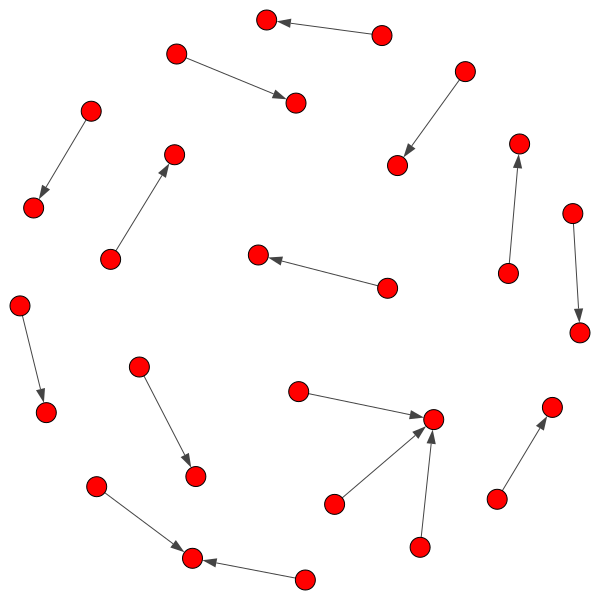

In [568]:
ig.plot(g, layout=layout)

In [569]:
print(tikz_code)

\begin{tikzpicture}
	\Vertex[x=-0.03, y=-0.91, label=$J$]{0}
	\Vertex[x=-1.19, y=-1.21, label=$J$]{1}
	\Vertex[x=1.06, y=-1.04, label=$J$]{2}
	\Vertex[x=1.16, y=-2.22, label=$K$]{3}
	\Vertex[x=-0.76, y=1.75, label=$M$]{4}
	\Vertex[x=-1.78, y=1.55, label=$I$]{5}
	\Vertex[x=-2.64, y=0.90, label=$M$]{6}
	\Vertex[x=-2.25, y=-0.19, label=$L$]{7}
	\Vertex[x=-1.75, y=0.81, label=$B$]{8}
	\Vertex[x=-3.32, y=-0.75, label=$J$]{9}
	\Vertex[x=-3.09, y=0.23, label=$B$]{10}
	\Vertex[x=-2.51, y=-1.17, label=$A$]{11}
	\Vertex[x=-1.94, y=-2.12, label=$B$]{12}
	\Vertex[x=-2.69, y=-2.52, label=$F$]{13}
	\Vertex[x=-3.20, y=-1.64, label=$B$]{14}
	\Vertex[x=-1.92, y=-3.04, label=$C$]{15}
	\Vertex[x=-0.85, y=-2.59, label=$D$]{16}
	\Vertex[x=0.67, y=-2.88, label=$G$]{17}
	\Vertex[x=0.06, y=-2.02, label=$H$]{18}
	\Vertex[x=-0.08, y=-3.21, label=$G$]{19}
	\Vertex[x=-1.11, y=-3.35, label=$B$]{20}
	\Vertex[x=-0.82, y=0.03, label=$G$]{21}
	\Vertex[x=0.39, y=0.29, label=$B$]{22}
	\Vertex[x=0.27, y=1.45, label=$G$]{